<a href="https://colab.research.google.com/github/bhuvnk/skunworks/blob/main/Phase1/2.%20RelationNet/RelationNet_MiniImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Relation Netwoks: Omniglot dataset


`Credit:` https://github.com/floodsung/LearningToCompare_FSL


# Important
Training Iterations on paper: 60,000 | Accuracy = 50.4

Implemented in this notebook : 5,000 | Accuracy = 41.5

## Mini Imagenet Data

Mini Imagenet pickle by some gentleman:
https://drive.google.com/file/d/1fJAK5WZTjerW7EWHHQAR9pRJVNg1T1Y7/view


In [1]:
# Download the MiniImagenet from Aauth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1fJAK5WZTjerW7EWHHQAR9pRJVNg1T1Y7"})   
downloaded.GetContentFile('miniImageNet.zip') 

In [2]:
!mkdir miniImageNet
!unzip -qq miniImageNet.zip -d miniImageNet

##Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import random
import pickle as pkl
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Reading the MiniImagenet

* 64 character | Background Set | Training
* 16 Alphabets | Evaluation Set | Testing


In [5]:
#data path
data_path = '/content/miniImageNet'
train_path = data_path + '/miniImageNet_category_split_train_phase_train.pickle'
val_path = data_path + '/miniImageNet_category_split_val.pickle'
test_path = data_path + '/miniImageNet_category_split_test.pickle'

In [8]:
def load_data(data_file):
    dataset = read_file(data_file)
    data = dataset['data']
    labels = dataset['labels']
    label2ind = buildLabelIndex(labels)

    return {key: np.array(data[val]) for (key, val) in tqdm(label2ind.items())}

def read_file(data_file):
    try:
        with open(data_file, 'rb') as fo:
            data = pkl.load(fo)
        return data
    except:
        with open(data_file, 'rb') as f:
            u = pkl._Unpickler(f)
            u.encoding = 'latin1'
            data = u.load()
        return data

def buildLabelIndex(labels):
    label2inds = {}
    for idx, label in enumerate(labels):
        if label not in label2inds:
            label2inds[label] = []
        label2inds[label].append(idx)

    return label2inds

# Task Sampler

In [9]:
# Read the training data
train_data = load_data(train_path)

##Create samples

In [10]:
def extract_sample(n_way, n_support, n_query, data):
  """
    Returns a Task with support and query set combined
    task sample : (n_way, n_support+n_query, (image dim))
    plus these info: n_way, n_support, n_query
  """
  sample = []
  # K = np.random.choice(data.keys(), n_way, replace=False)
  K = random.sample(data.keys(), n_way)

  for cls in K:
    datax_cls = data[cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)/255.
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return sample

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [11]:
sample_example = extract_sample(8, 5, 5, train_data)
sample_example.shape

torch.Size([8, 10, 3, 84, 84])

In [12]:
#Just checking how it's gonna be used in forward function
sample_ex = sample_example.contiguous().view(8 * 10, *sample_example.size()[2:])
sample_ex.shape

torch.Size([80, 3, 84, 84])

In [14]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

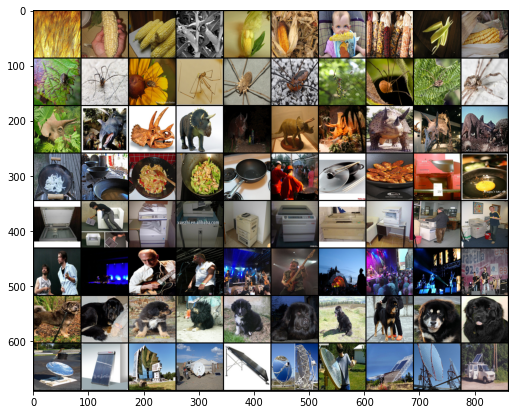

In [15]:
display_sample(sample_example)

##Build model

In [65]:
## Encoder
class CNNEncoder(nn.Module):
    """Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))

    def forward(self,x):
        out = self.layer1(x)    # 84 | 84 | 82 | 41 
        out = self.layer2(out)  # 41 | 41 | 39 | 20 
        out = self.layer3(out)  # 20 | 21 | 19 | 10
        out = self.layer4(out)  # 10 | 11 |  9 | 5
        #out = out.view(out.size(0),-1)
        return out # 64

In [66]:
class RelationNetwork(nn.Module):
    '''Decoder: relation part'''
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(128,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

In [67]:
def weights_init(m):
    classname = m.__class__.__name__
    import math
    if classname.find('Conv') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        n = m.weight.size(1)
        m.weight.data.normal_(0, 0.01)
        m.bias.data = torch.ones(m.bias.data.size())

##Train

In [68]:
from tqdm import tqdm_notebook
from tqdm import tnrange

def train(feature_encoder,relation_network,
          feature_encoder_optim, relation_network_optim,
          data,
          n_way, n_support, n_query,
          episodes=1000, epochs=1):

    # Step 1: neural networks
    print("init neural networks")

    feature_encoder.cuda()
    relation_network.cuda()

    feature_encoder_scheduler = optim.lr_scheduler.StepLR(feature_encoder_optim,step_size=100000,gamma=0.5)
    relation_network_scheduler = optim.lr_scheduler.StepLR(relation_network_optim,step_size=100000,gamma=0.5)

    # Step 2: Start Training
    print("Training...")

    # last_accuracy = 0.0

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        running_acc = 0.0

        pbar = tqdm(total=episodes, desc='Epoch {}'.format(epoch))

        for episode in range(episodes):

            # batch_dataloader is to batch samples for training
            sample_images = extract_sample(n_way, n_support, n_query, data)
            sample_images = sample_images.cuda()

            x_support = sample_images[:, :n_support].contiguous().view(n_way * n_support, *sample_images.size()[2:])
            x_query = sample_images[:, n_support:].contiguous().view(n_way * n_query, *sample_images.size()[2:])

            #target indices are 0 ... n_way-1
            # target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
            # target_inds = Variable(target_inds, requires_grad=False)
            # target_inds = target_inds.cuda()

            target_inds = torch.arange(0, n_way).view(n_way, 1).expand(n_way, n_query).reshape(n_way*n_query,1).long()
            one_hot_labels = Variable(torch.zeros(n_query*n_way, n_way).scatter_(1, target_inds.view(-1,1), 1), requires_grad=False)
            one_hot_labels = one_hot_labels.cuda()

            # calculate features
            support_features = feature_encoder(x_support) # 5x64*5*5
            # print(support_features.shape)
            support_features = support_features.view(n_way,n_support,feature_dim,5,5)
            support_features = torch.sum(support_features,1).squeeze(1)
            query_features = feature_encoder(x_query) # 20x64*5*5

            # calculate relations
            # each query sample link to every support samples to calculate relations
            # to form a n_way*n_supportx128 matrix for relation network
            support_features_ext = support_features.unsqueeze(0).repeat(n_query*n_way,1,1,1,1)
            query_features_ext = query_features.unsqueeze(0).repeat(n_way,1,1,1,1)
            query_features_ext = torch.transpose(query_features_ext,0,1)

            relation_pairs = torch.cat((support_features_ext,query_features_ext),2).view(-1,feature_dim*2,5,5)
            relations = relation_network(relation_pairs).view(-1,n_way)

            mse = nn.MSELoss().cuda()
            loss = mse(relations,one_hot_labels)

            _,predict_labels = torch.max(relations.data,1)
            _,target_labels = torch.max(one_hot_labels.data,1) # just some lazy code
                      
            
            rewards = [1 if predict_labels[j]==target_labels[j] else 0 for j in range(n_way*n_support)]
            acc = (np.sum(rewards)/(n_way*n_support))

            running_acc += acc
            running_loss += loss

            feature_encoder.zero_grad()
            relation_network.zero_grad()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(feature_encoder.parameters(),0.5)
            torch.nn.utils.clip_grad_norm_(relation_network.parameters(),0.5)

            feature_encoder_optim.step()
            relation_network_optim.step()

            feature_encoder_scheduler.step()
            relation_network_scheduler.step()

            # Progress Bar Logging
            pbar.update(1)
            pbar.set_postfix({'Loss': loss.item(), 
                              'Acc': acc.item()})
        
        pbar.close()
        epoch_loss = running_loss / episodes
        epoch_acc = running_acc / episodes
        # print(f'epoch:{epoch+1}; loss: {epoch_loss.value()}; Accuracy: {epoch_acc.value()}')  
        print(f'epoch:{epoch}; loss: {epoch_loss.item()}; Accuracy: {epoch_acc.item()}')  

# Start Trainning

In [69]:
episodes = 1000
epochs = 5
n_way, n_support, n_query = 5, 1, 15

In [70]:
lr= 0.001

## Relationnet stuff
feature_dim = 64
relation_dim = 8

feature_encoder = CNNEncoder()
relation_network = RelationNetwork(feature_dim, relation_dim)

# feature_encoder.apply(weights_init)
# relation_network.apply(weights_init)

feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=lr)
relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=lr)



In [71]:
train(feature_encoder,relation_network,
          feature_encoder_optim, relation_network_optim,
          train_data,
          n_way, n_support, n_query,
          episodes=episodes, epochs=epochs)

init neural networks
Training...



epoch:1; loss: 0.15301193296909332; Accuracy: 0.3235999999999993



epoch:2; loss: 0.1476614773273468; Accuracy: 0.3625999999999985



epoch:3; loss: 0.14238707721233368; Accuracy: 0.40159999999999896



epoch:4; loss: 0.1367807537317276; Accuracy: 0.4501999999999995



epoch:5; loss: 0.13527563214302063; Accuracy: 0.4687999999999997


In [72]:
torch.save({'feature_encoder': feature_encoder.state_dict(),
            'relation_network': relation_network.state_dict()}, "Model_para.pth")

##Test

In [75]:
from tqdm import tqdm_notebook
from tqdm import tnrange

def test(feature_encoder,relation_network,
          feature_encoder_optim, relation_network_optim,
          data,
          n_way, n_support, n_query,
          episodes=1000, epochs=1):

    # Step 1: neural networks
    print("init neural networks")

    feature_encoder.cuda()
    relation_network.cuda()
    
    # Step 2: Start Testing
    print("Testing...")

    # last_accuracy = 0.0

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        running_acc = 0.0

        pbar = tqdm(total=episodes, desc='Epoch {}'.format(epoch))
        with torch.no_grad():

            for episode in range(episodes):

                # batch_dataloader is to batch samples for training
                sample_images = extract_sample(n_way, n_support, n_query, data)
                sample_images = sample_images.cuda()

                x_support = sample_images[:, :n_support].contiguous().view(n_way * n_support, *sample_images.size()[2:])
                x_query = sample_images[:, n_support:].contiguous().view(n_way * n_query, *sample_images.size()[2:])

                target_inds = torch.arange(0, n_way).view(n_way, 1).expand(n_way, n_query).reshape(n_way*n_query,1).long()
                one_hot_labels = Variable(torch.zeros(n_query*n_way, n_way).scatter_(1, target_inds.view(-1,1), 1), requires_grad=False)
                one_hot_labels = one_hot_labels.cuda()

                # calculate features
                support_features = feature_encoder(x_support) # 5x64*5*5
                support_features = support_features.view(n_way,n_support,feature_dim,5,5)
                support_features = torch.sum(support_features,1).squeeze(1)
                query_features = feature_encoder(x_query) # 20x64*5*5

                # calculate relations

                support_features_ext = support_features.unsqueeze(0).repeat(n_query*n_way,1,1,1,1)
                query_features_ext = query_features.unsqueeze(0).repeat(n_way,1,1,1,1)
                query_features_ext = torch.transpose(query_features_ext,0,1)

                relation_pairs = torch.cat((support_features_ext,query_features_ext),2).view(-1,feature_dim*2,5,5)
                relations = relation_network(relation_pairs).view(-1,n_way)

                mse = nn.MSELoss().cuda()
                loss = mse(relations,one_hot_labels)

                _,predict_labels = torch.max(relations.data,1)
                _,target_labels = torch.max(one_hot_labels.data,1) # lazy coding
                          
                
                rewards = [1 if predict_labels[j]==target_labels[j] else 0 for j in range(n_way*n_support)]
                acc = (np.sum(rewards)/(n_way*n_support))

                running_acc += acc
                running_loss += loss

                # Progress Bar Logging
                pbar.update(1)
                pbar.set_postfix({'Loss': loss.item(), 
                                  'Acc': acc.item()})
            
            pbar.close()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            # print(f'epoch:{epoch+1}; loss: {epoch_loss.value()}; Accuracy: {epoch_acc.value()}')  
            print(f'epoch:{epoch}; loss: {epoch_loss.item()}; Accuracy: {epoch_acc.item()}')  

In [76]:
n_way = 5
n_support = 1
n_query = 15

test_episode = 1000

In [77]:
test_data = load_data(val_path)

In [78]:
# # Load Checkpoint
checkpoint = torch.load('/content/Model_para.pth')
feature_encoder = CNNEncoder()
relation_network = RelationNetwork(feature_dim,relation_dim)
feature_encoder.load_state_dict(checkpoint['feature_encoder'])
relation_network.load_state_dict(checkpoint['relation_network'])


feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=lr)
relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=lr)

feature_encoder_scheduler = optim.lr_scheduler.StepLR(feature_encoder_optim,step_size=100000,gamma=0.5)
relation_network_scheduler = optim.lr_scheduler.StepLR(relation_network_optim,step_size=100000,gamma=0.5)


In [79]:
test(feature_encoder,relation_network,
     feature_encoder_optim, relation_network_optim,
     test_data,
     n_way, n_support, n_query,
     episodes=test_episode)

init neural networks
Testing...



epoch:1; loss: 0.14433248341083527; Accuracy: 0.4145999999999985
